In [2]:
!pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=7f2f6307d523a1c2f74f87bdbc58ed6b7745e606de713170b2ad81002de49924
  Stored in directory: c:\users\mdp\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor


In [2]:
from numpy.random import seed
seed(101)
import pandas as pd
import numpy as np
#import keras

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import  Dropout,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy

import os

from sklearn.model_selection import train_test_split
import shutil
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.listdir(r'C:\Users\MDP\Documents\Proje_B\Inputs')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [8]:
base_dir = 'base_dir'
os.mkdir(base_dir)

val_dir = os.path.join(base_dir, 'val_dir')# validation file
os.mkdir(val_dir)

train_dir = os.path.join(base_dir, 'train_dir')# train file
os.mkdir(train_dir)

# train dosyasının içerisine kanser türlerinin görüntülerini içerecek dosyaları oluştur
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

#Validation dosyasının içerisine de aynı şekilde dosyaları oluştur
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [4]:
df_data = pd.read_csv(r'C:\Users\MDP\Documents\Proje_B\Inputs\HAM10000_metadata.csv')
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
df_data.count()

lesion_id       10015
image_id        10015
dx              10015
dx_type         10015
age              9958
sex             10015
localization    10015
dtype: int64

<AxesSubplot:>

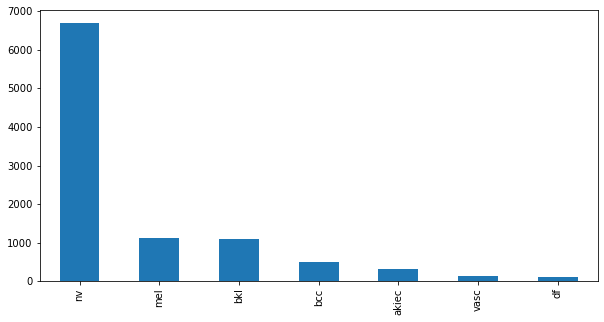

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df_data['dx'].value_counts().plot(kind='bar', ax=ax1)

<AxesSubplot:>

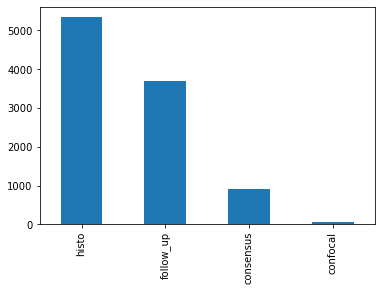

In [12]:
df_data['dx_type'].value_counts().plot(kind='bar')

<AxesSubplot:>

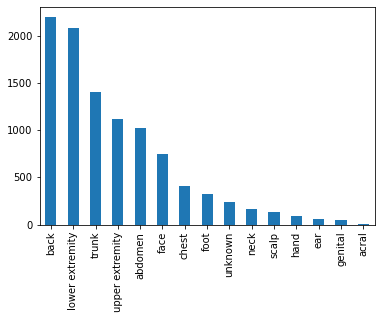

In [13]:
df_data['localization'].value_counts().plot(kind='bar',stacked=True)

<AxesSubplot:>

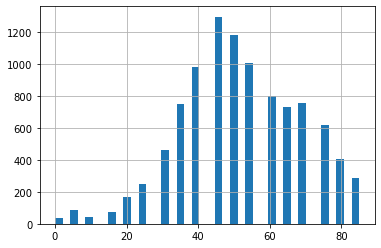

In [14]:
df_data['age'].hist(bins=40)

<AxesSubplot:>

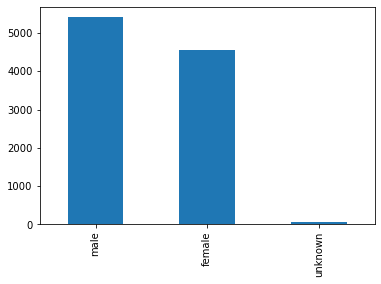

In [15]:
df_data['sex'].value_counts().plot(kind='bar')

In [16]:
#Her bir lesion_id ile kaç adet resmin ilişkili??

df = df_data.groupby('lesion_id').count()
#tek resime sahip olanlar..
df = df[df['image_id'] == 1]
df.reset_index(inplace = True)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [17]:
#tekrar etmiş ve tek resim içeren lesion_id'ler.

def get_repeated(x):
    unique_list = list(df['lesion_id'])
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
df_data['duplicates'] = df_data['lesion_id']
df_data['duplicates'] = df_data['duplicates'].apply(get_repeated)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [18]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [19]:
#filter not repeated
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [20]:
#Verilerin tekrar etmemesi sağlandı
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)
df_val.shape

(938, 8)

In [21]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [22]:
# Validation ve train verilerinin okunması
def identify_val_rows(x):
    val_list = list(df_val['image_id'])    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

df_data['train_or_val'] = df_data['image_id']
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
df_train = df_data[df_data['train_or_val'] == 'train']

print(len(df_train))
print(len(df_val))

9077
938


In [23]:
df_train['dx'].value_counts()

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [24]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [25]:
#İmage_id yi index biçiminde
df_data.set_index('image_id', inplace=True)

In [26]:
folder_1 = os.listdir(r'C:\Users\MDP\Documents\Proje_B\Inputs\ham10000_images_part_1')
folder_2 = os.listdir(r'C:\Users\MDP\Documents\Proje_B\Inputs\ham10000_images_part_2')

train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

#Train dosyalarını transfer ediyoruz.

for image in train_list:
    
    fname = image + '.jpg'#file name
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # Resmin kaynağı
        src = os.path.join(r'C:\Users\MDP\Documents\Proje_B\Inputs\ham10000_images_part_1', fname)
        # Varış noktası
        dst = os.path.join(train_dir, label, fname)
        # Kaynaktan varış noktasına kopyalama işlemi.
        shutil.copyfile(src, dst)
    if fname in folder_2:
        # Resmin kaynağı
        src = os.path.join(r'C:\Users\MDP\Documents\Proje_B\Inputs\ham10000_images_part_2', fname)
        # Varış noktası
        dst = os.path.join(train_dir, label, fname)
        # Kaynaktan varış noktasına kopyalama işlemi
        shutil.copyfile(src, dst)

# Validation dosyalarını transfer ediyoruz.

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # Resmin kaynağı
        src = os.path.join(r'C:\Users\MDP\Documents\Proje_B\Inputs\ham10000_images_part_1', fname)
        # Varış noktası
        dst = os.path.join(val_dir, label, fname)
        # Kaynaktan varış noktasına kopyalama işlemi
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # Resmin kaynağı
        src = os.path.join(r'C:\Users\MDP\Documents\Proje_B\Inputs\ham10000_images_part_2', fname)
        # Varış noktası
        dst = os.path.join(val_dir, label, fname)
        # Kaynaktan varış noktasına kopyalama işlemi
        shutil.copyfile(src, dst)

In [27]:
#Check train data

print('NV:',len(os.listdir('base_dir/train_dir/nv')))
print('MEL:',len(os.listdir('base_dir/train_dir/mel')))
print('BKL:',len(os.listdir('base_dir/train_dir/bkl')))
print('BCC:',len(os.listdir('base_dir/train_dir/bcc')))
print('Akiec:',len(os.listdir('base_dir/train_dir/akiec')))
print('Vasc:',len(os.listdir('base_dir/train_dir/vasc')))
print('DF:',len(os.listdir('base_dir/train_dir/df')))

NV: 5954
MEL: 1074
BKL: 1024
BCC: 484
Akiec: 301
Vasc: 131
DF: 109


In [28]:
#Check val data

print('NV:',len(os.listdir('base_dir/val_dir/nv')))
print('MEL:',len(os.listdir('base_dir/val_dir/mel')))
print('BKL:',len(os.listdir('base_dir/val_dir/bkl')))
print('BCC:',len(os.listdir('base_dir/val_dir/bcc')))
print('Akiec:',len(os.listdir('base_dir/val_dir/akiec')))
print('Vasc:',len(os.listdir('base_dir/val_dir/vasc')))
print('DF:',len(os.listdir('base_dir/val_dir/df')))

NV: 751
MEL: 39
BKL: 75
BCC: 30
Akiec: 26
Vasc: 11
DF: 6


### DATA AUGMENTATION 

In [29]:
# 'nv' sınıfı çoklanmayacak
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item
    img_list = os.listdir('base_dir/train_dir/' + img_class)
    
    for fname in img_list:
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)

    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class
    
    # Data Generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)
        
    ###########
    
    num_aug_images_wanted = 6000 # Çoklanacak sayı
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    for i in range(0,num_batches):
        imgs, labels = next(aug_datagen)
        
    # Geçici klasör siliniyor
    shutil.rmtree('aug_dir')

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [30]:
#Check train data after data augmentation

print('NV:',len(os.listdir('base_dir/train_dir/nv')))
print('MEL:',len(os.listdir('base_dir/train_dir/mel')))
print('BKL:',len(os.listdir('base_dir/train_dir/bkl')))
print('BCC:',len(os.listdir('base_dir/train_dir/bcc')))
print('Akiec:',len(os.listdir('base_dir/train_dir/akiec')))
print('Vasc:',len(os.listdir('base_dir/train_dir/vasc')))
print('DF:',len(os.listdir('base_dir/train_dir/df')))

NV: 5954
MEL: 5920
BKL: 5920
BCC: 5858
Akiec: 5217
Vasc: 5290
DF: 4410


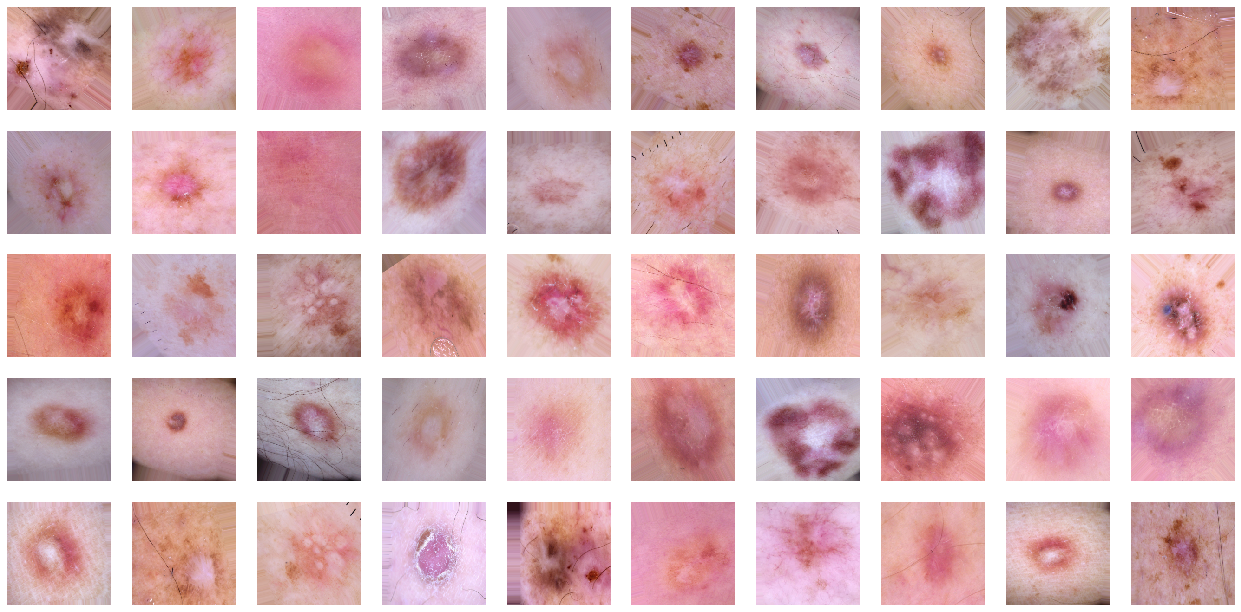

In [9]:
def plots(ims, figsize=(22,11), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None)

### Create MODEL

In [48]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [32]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Not: shuffle=False komutu test datasının karıştırılmamasına neden olur.
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [33]:
# Mobile Net Modelini indiriyor ve kopyalıyoruz.

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 67s 4us/step


In [34]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [35]:
len(mobile.layers)

91

In [36]:
#Model yapısını oluşturma.

# Modelin son 5 katmanını dışarıda tutacağız.
x = mobile.layers[-6].output

# Tahmin için yeni bir dense layer oluşturuyoruz.
# 7 class sayımızı ifade ediyor.
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input input layerı seçer, outputs=predictions dense layerı işaret eder.

model = Model(inputs=mobile.input, outputs=predictions)

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [40]:
#Yeni modeldeki son 23 katman dışında hepsini doldur
#Modelin son 23 katmanı eğitilecek

for layer in model.layers[:-23]:
    layer.trainable = False

### TRAIN MODEL

In [50]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [52]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [53]:
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [55]:
# Ağırlıkları Melonoma türüne daha hassas olacak şekilde düzenle
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel       
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [72]:
filepath = "model_kanser.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [checkpoint, reduce_lr]